# Применение методологии Бокса-Дженкинса для анализа смертности вследствие несчастных случаев в Америке в период 1973-1976 гг и построение прогноза на 1977 г #

In [2]:
import pandas as pd
import numpy as np
import itertools
import warnings
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa import stattools
from scipy.stats import wilcoxon

### Этап 1. Идентификация модели ### 
Необходимо провести визуальный анализ данных и коррелограмм, воспользоваться критерием Дики-Фуллера, который проверяет 
основную гипотезу о наличии единичных корней в простейшей авторегрессионной модели, описывающей данные;
данный критерий можно интерпретировать как проверку на наличие нестационарности

         deaths
Month          
1973-01    9007
1973-02    8106
1973-03    8928
1973-04    9137
1973-05   10017
Dickey-Fuller:Statistics -2.848594793904182 pvalue 0.051660604709218856


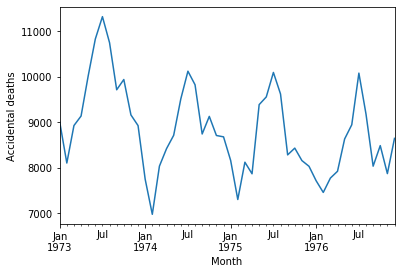

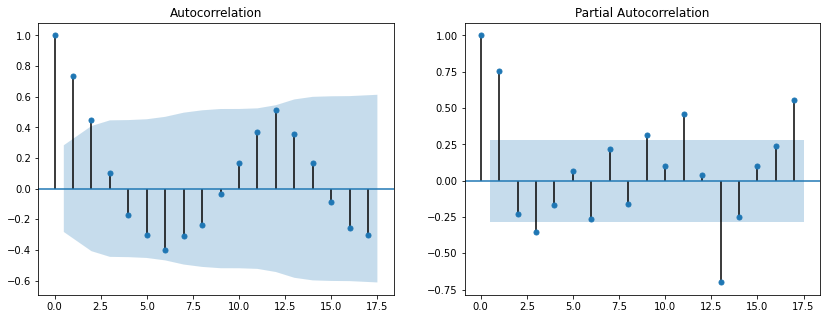

In [3]:
#avrg-month accidental road death rate in USA
death_df = pd.read_csv('../data_sets/accidental-deaths-in-usa-monthly.csv', index_col=['Month'], parse_dates=['Month'])
death_df.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978': 'deaths'}, inplace=True)
death_df.index = death_df.index.to_period('M')
#death_df.size=72
train_df = death_df[:48].copy()
print(train_df.head());
train_df['deaths'].plot()
plt.ylabel('Accidental deaths')
result = stattools.adfuller(train_df['deaths'], autolag="t-stat")
print(f"Dickey-Fuller:Statistics {result[0]}", f"pvalue {result[1]}")
fig, ax = plt.subplots(figsize=(14, 5))
ax_acf = plt.subplot(121)
sm.graphics.tsa.plot_acf(train_df['deaths'], ax=ax_acf)
ax_pacf = plt.subplot(122)
ax = sm.graphics.tsa.plot_pacf(train_df['deaths'], ax=ax_pacf);

Критерий Дики-Фуллера не отвергает нулевую гипотезу на уровне значимости 0.05.  
Используем сезонную разность

Dickey-Fuller:Statistics -2.5965094428576605 pvalue 0.09372084281009907


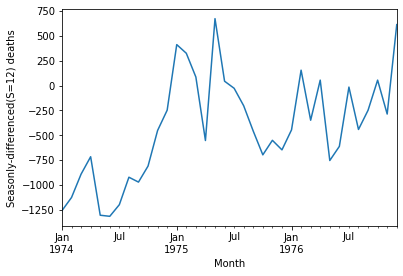

In [4]:
train_df['deaths_ssnl_diff'] = train_df['deaths'] - train_df['deaths'].shift(12)
result = stattools.adfuller(train_df['deaths_ssnl_diff'][12:], autolag="t-stat") #shift(12)=>first 12 values are NAN
print(f"Dickey-Fuller:Statistics {result[0]}", f"pvalue {result[1]}")
train_df['deaths_ssnl_diff'][12:].plot()
plt.ylabel('Seasonly-differenced(S=12) deaths');

После применения сезонного дифференцирования критерий Дики-Фуллера не отвергает основную гипотезу о нестационарности на уровне значимости 0.05  
Визуально заметен небольшой тренд, поэтому следует применить разность первого порядка к ряду

Dickey-Fuller:Statistics -8.356141865549068 pvalue 2.9057165396048613e-13


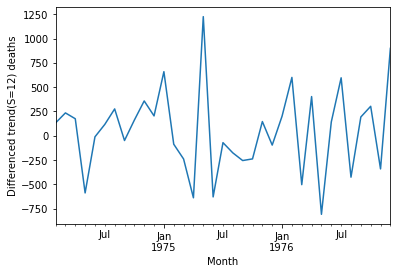

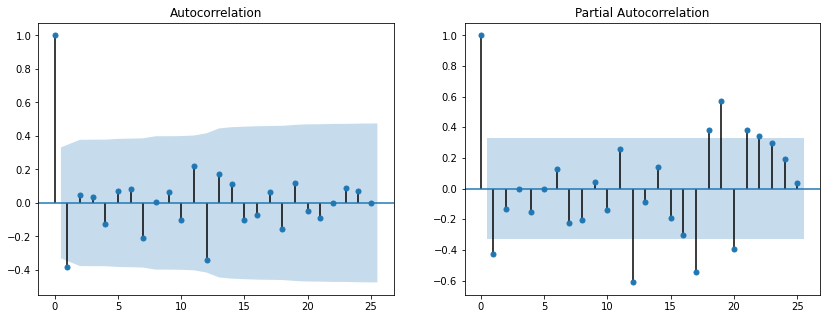

In [5]:
train_df['diff_deaths_ssnl_diff'] = train_df['deaths_ssnl_diff'] - train_df['deaths_ssnl_diff'].shift(1)
result = stattools.adfuller(train_df['diff_deaths_ssnl_diff'][13:], autolag="t-stat") #shift(13)=>first 13 values are NAN
print(f"Dickey-Fuller:Statistics {result[0]}", f"pvalue {result[1]}")
train_df['diff_deaths_ssnl_diff'][13:].plot()
plt.ylabel('Differenced trend(S=12) deaths')
fig, ax = plt.subplots(figsize=(14, 5))
ax_acf = plt.subplot(121)
sm.graphics.tsa.plot_acf(train_df['diff_deaths_ssnl_diff'][13:], lags=25, ax=ax_acf)
ax_pacf = plt.subplot(122)
ax = sm.graphics.tsa.plot_pacf(train_df['diff_deaths_ssnl_diff'][13:], method='ols', lags=25, ax=ax_pacf);

Коррелограмма *ACF* резко затухает после лага 1 и имеет значимый сезонный лаг 12.  
Коррелограмма *PACF* резко затухает после лага 1, также на ней прослеживается значимый сезонный лаг 24. С другой стороны незначительные колебания лагов в околосезонной области могут быть последствием влияния сезонности скользящего среднего.  
Предполагаемые модели исходного ряда: SARIMA(1,1,1)x(2,1,0)(12), SARIMA(1,1,1)x(0,1,1)(12)
### Этап 2-3 Оценивание коэффициентов модели, диагностика построенных моделей ###  
Формируются наборы доступных параметров модели, исходя из вышесделанных выводов. Для каждого набора параметров строится модель, затем полученные таким образом модели сравниваются по критерию Акаике - модель с наименьшим значением критерия считается лучшей 

In [6]:
p = range(0, 3)
q = range(0, 3)
d = 1
P = range(0, 3)
D = 1
Q = (0, 1)
model_list = []
best_aic = float("inf")
best_model = None
arima_params = list(itertools.product(p,q))
seasonal_params = list(itertools.product(P,Q))
warnings.filterwarnings('ignore')
for pq in arima_params:
    for PQ in seasonal_params:
        try:
            model = model=sm.tsa.statespace.SARIMAX(train_df['deaths'], order=(pq[0], d, pq[1]), 
                                                    seasonal_order=(PQ[0], D, PQ[1], 12)).fit(disp=False)
        except ValueError:
            continue
        aic = model.aic
        if(aic < best_aic):
            best_aic = aic
            best_model = model
        model_list.append([(pq[0],d,pq[1]), (PQ[0], 1, PQ[1]), model.aic]);
model_table = pd.DataFrame(model_list)
model_table.columns = ['pdq', 'PDQ', 'aic']
print(model_table.sort_values(by='aic', ascending='True').head())
print(best_model.summary())

          pdq        PDQ         aic
7   (0, 1, 1)  (0, 1, 1)  517.265322
19  (1, 1, 0)  (0, 1, 1)  517.406201
8   (0, 1, 1)  (1, 1, 0)  517.985233
20  (1, 1, 0)  (1, 1, 0)  518.403364
1   (0, 1, 0)  (0, 1, 1)  518.766968
                                     SARIMAX Results                                      
Dep. Variable:                             deaths   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -255.633
Date:                            Thu, 28 May 2020   AIC                            517.265
Time:                                    23:48:46   BIC                            521.931
Sample:                                01-31-1973   HQIC                           518.876
                                     - 12-31-1976                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P

SARIMA(0,1,1)x(0,1,1)(12) по критерию Акаике показала лучший результат 
Теперь необходимо проверить остатки выбранной модели на несмещенность критерием Вилкоксона, на некоррелированность критерием Льюнга-Бокса, на стационарность критерием Дики-Фуллера, проанализировать коррелограмму.

Wilcoxon:Statistics 299.0 pvalue, 0.793270337259859
Dickey-Fuller:Statistics -3.3451830793939354 pvalue 0.012975702747151367
       Q-stat   p-value
0    1.178978  0.277564
1    1.192927  0.550756
2    1.332859  0.721346
3    4.699468  0.319546
4    5.351002  0.374561
5    5.608843  0.468400
6    6.890222  0.440399
7    6.937775  0.543361
8    6.943185  0.643035
9    7.550286  0.672671
10   8.614035  0.657470
11   9.193840  0.686291
12   9.890992  0.702823
13  14.213453  0.433933
14  17.447848  0.292804
15  17.572896  0.349493
16  17.572953  0.416248
17  19.774087  0.345681
18  22.115777  0.278532
19  24.125441  0.236956
20  25.392105  0.230581
21  25.474819  0.274912
22  25.738925  0.313345
23  26.008103  0.352754
24  26.981594  0.356805


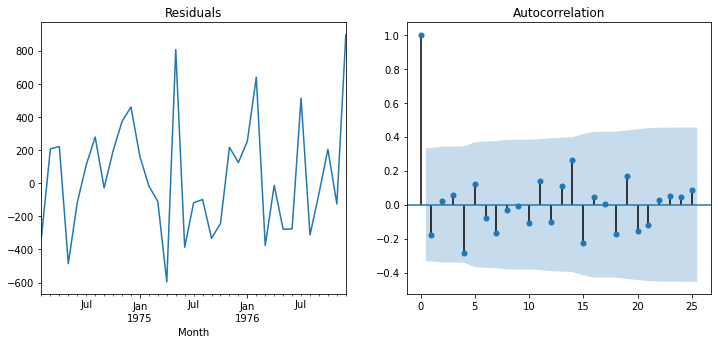

In [7]:
train_df['modeled'] = best_model.fittedvalues
q_test = stattools.acf(best_model.resid[13:], qstat=True, nlags=25) #was diff for 13
wilcox = wilcoxon(best_model.resid[13:])
print(f"Wilcoxon:Statistics {wilcox[0]}", f"pvalue, {wilcox[1]}")
result = stattools.adfuller(best_model.resid[13:], autolag="t-stat")
print(f"Dickey-Fuller:Statistics {result[0]}", f"pvalue {result[1]}")
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))
fig, ax = plt.subplots(figsize=(12, 5))
# ax_df = plt.subplot(131)
# ax_df.set_title('Accidental deaths')
# ax = train_df['deaths'].plot(ax=ax_df)
# ax = train_df['modeled'][13:].plot(ax=ax_df)
ax_errs = plt.subplot(121)
ax_errs.set_title('Residuals')
ax = best_model.resid[13:].plot(ax=ax_errs)
ax_acf = plt.subplot(122)
ax = sm.graphics.tsa.plot_acf(best_model.resid[13:], lags=25, ax = ax_acf);

На уровне значимости 0.05 критерий Вилкоксона не отвергает нулевую гипотезу о несмещенности   
Q-статистика имеет распределение хи-квадрат при уровне значимости 0.05 на рассматриваемых лагах - гипотеза о некоррелированности не отвергается.   
Критерий Дики-Фуллера отвергает нулевую гипотезу о нестационарности
### Этап 4 построение прогноза по выбранной модели ###  

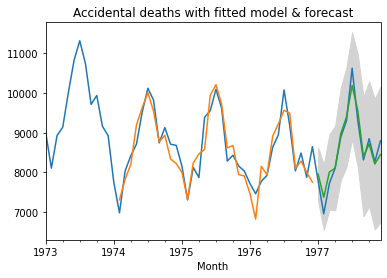

In [8]:
#forecast
forecast = best_model.get_forecast(steps=12,alpha=0.05).summary_frame()
forecast['errors'] = death_df['deaths'][48:60] - forecast['mean']
death_df['deaths'][:60].plot()
train_df['modeled'][13:].plot()
forecast['mean'].plot()
plt.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='lightgrey');
plt.title('Accidental deaths with fitted model & forecast');

Анализ ошибок прогноза и последующий вывод

Wilcoxon:Statistics 31.0 pvalue, 0.5302845968336095
Dickey-Fuller:Statistics -2.367876661637562 pvalue 0.15100896245433004
      Q-stat   p-value
0   0.107440  0.743078
1   0.122523  0.940577
2   0.517522  0.915025
3   1.460127  0.833680
4   1.569856  0.904870
5   1.577890  0.954154
6   1.584801  0.979228
7   1.970657  0.981898
8   4.675735  0.861610
9   9.096422  0.522978
10  9.982277  0.531982
forecast RMSE:195.46851128277171


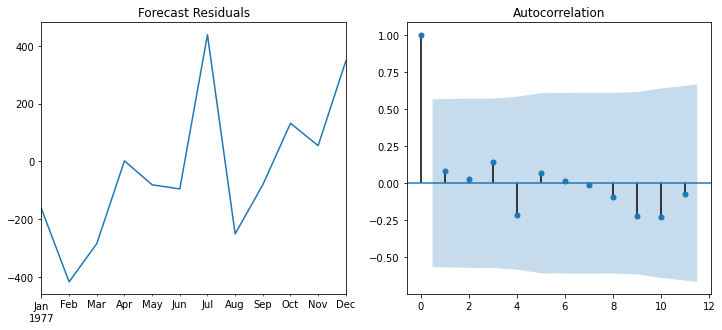

In [9]:
wilcox = wilcoxon(forecast['errors'])
print(f"Wilcoxon:Statistics {wilcox[0]}", f"pvalue, {wilcox[1]}")
result = stattools.adfuller(forecast['errors'], autolag="t-stat")
print(f"Dickey-Fuller:Statistics {result[0]}", f"pvalue {result[1]}")
q_test = stattools.acf(forecast['errors'], qstat=True)
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))
print(f"forecast RMSE:{np.sqrt(forecast['errors']**2).mean()}")
fig, ax = plt.subplots(figsize=(12, 5))
# ax_df = plt.subplot(131)
# ax_df.set_title('Accidental deaths')
# ax = train_df['deaths'].plot(ax=ax_df)
# ax = train_df['modeled'][13:].plot(ax=ax_df)
ax_errs = plt.subplot(121)
ax_errs.set_title('Forecast Residuals')
ax = forecast['errors'].plot(ax=ax_errs)
ax_acf = plt.subplot(122)
ax = sm.graphics.tsa.plot_acf(forecast['errors'], ax = ax_acf);

### Вывод ### 
Критерии Льюнга-Бокса и Вилкоксона не отвергают нулевые гипотезы о некоррелированности и несмещенности, однако, критерий Дики-Фуллера не отвергает нулевую гипотезу о нестационарности. Визуально на графике остатков прогноза заметен небольшой тренд, который является следствием наименьшей смертности на начало 1977 года относительно рассматриваемого промежутка времени. В целом, прогноз можно считать приемлимым

In [15]:
#mape
print(f"MAPE:{(forecast['errors'].abs() / death_df['deaths'][48:60]).mean()*100}%")
# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE:2.3010109912099064%
